## Spark Context and Imports

In [1]:
import os, re, sys, utilities
spark_home = os.environ.get('SPARK_HOME', None)

In [2]:
import sys
sys.version_info

sys.version_info(major=3, minor=6, micro=8, releaselevel='final', serial=0)

In [3]:
code = utilities.getSparkContext()
exec(code)

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.3.2.3.1.4.39-6
      /_/

Using Python version 3.6.8 (default, Dec 30 2018 01:22:34)
SparkSession available as 'spark'.


In [4]:
from pyspark import SparkContext
#from pyspark.sql import SparkSession, HiveContext

In [5]:
from pyspark_llap.sql.session import HiveWarehouseSession
from pyspark.sql import SparkSession

hive = HiveWarehouseSession.session(spark).build()

In [6]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import datetime
import math
import scipy

In [7]:
from pyspark.sql.functions import col, udf, countDistinct, isnan, when, count, to_date, from_unixtime, unix_timestamp, min, max, row_number
from pyspark.sql.window import Window
from pyspark.sql.types import Row
from pyspark.sql.functions import year, month, dayofmonth, hour

In [8]:
from pyspark.sql.types import DoubleType, FloatType, BooleanType, LongType, \
IntegerType, TimestampType, StringType, StructType, StructField, ArrayType

### Read Trip Summary Table (filtered using query)

In [ ]:
# filtered trip summary data, original
trip_sum_NA_raw = spark.sql("""SELECT T1.cvdcqa_vin_d_3 AS vin,
coalesce(T1.cvdcqa_oil_chng_cyc_no_r_3,0) AS oil_change_cycle_number,
T1.cvdcqa_trip_no_r_3 AS trip_number,
to_date(T1.cvdcqa_trip_end_time_s_3) AS trip_end_date,
T1.cvdcqa_trip_end_eng_oil_p_3 AS trip_end_eng_oil_percent,
T1.cvdcqa_trip_end_odo_read_r_3 AS trip_end_odo_read
FROM cvdp.NCVDCQA_TRIP_SUM_FINAL_SEC_HTE T1
WHERE T1.cvdcqa_suspect_flag_r_3 = 0 AND
T1.cvdcqa_trip_no_r_3 IS NOT NULL AND
T1.cvdcqa_trip_end_time_s_3 IS NOT NULL AND
T1.cvdcqa_trip_end_eng_oil_p_3 IS NOT NULL AND
T1.cvdcqa_trip_end_odo_read_r_3 IS NOT NULL AND
T1.cvdcqa_vin_d_3 IS NOT NULL AND
T1.cvdcqa_partition_cntry_x = 'USA' AND
year(T1.cvdcqa_trip_end_time_s_3) > 2015""")

In [9]:
# filtered trip summary data
#to_timestamp(T1.cvdcqa_trip_end_time_s_3) AS trip_end_date,
trip_sum_CN = spark.sql("""SELECT T1.cvdcqa_vin_d_3 AS vin,
to_date(T1.cvdcqa_trip_end_time_s_3) as trip_end_date,
split(to_timestamp(T1.cvdcqa_trip_end_time_s_3),' ')[1] as trip_end_time,
from_unixtime(unix_timestamp(T1.cvdcqa_trip_end_time_s_3),'EEEE') as weekday,
T1.cvdcqa_mvemodyr7 AS model_year,
T1.cvdcqa_vehicle_description888_x_3 AS veh_dsc,
row_number() over(order by T1.cvdcqa_vin_d_3, T1.cvdcqa_trip_end_time_s_3) as msg_id
FROM cvdp.NCVDCQA_TRIP_SUM_FINAL_SEC_HTE T1
WHERE T1.cvdcqa_suspect_flag_r_3 = 0 AND
T1.cvdcqa_trip_no_r_3 IS NOT NULL AND
T1.cvdcqa_trip_end_time_s_3 IS NOT NULL AND
T1.cvdcqa_trip_end_odo_read_r_3 IS NOT NULL AND
T1.cvdcqa_vin_d_3 IS NOT NULL AND
T1.cvdcqa_partition_cntry_x = 'CAN' AND
year(T1.cvdcqa_trip_end_time_s_3) > 2015""")

In [9]:
# filtered trip summary data - NA  Multi VINs
trip_sum_multi = spark.sql("""SELECT T1.cvdcqa_vin_d_3 AS vin,
to_date(T1.cvdcqa_trip_end_time_s_3) as trip_end_date,
split(to_timestamp(T1.cvdcqa_trip_end_time_s_3),' ')[1] as trip_end_time,
from_unixtime(unix_timestamp(T1.cvdcqa_trip_end_time_s_3),'EEEE') as weekday,
T1.cvdcqa_mvemodyr7 AS model_year,
T1.cvdcqa_vehicle_description888_x_3 AS veh_dsc,
row_number() over(order by T1.cvdcqa_vin_d_3, T1.cvdcqa_trip_end_time_s_3) as msg_id
FROM cvdp.NCVDCQA_TRIP_SUM_FINAL_SEC_HTE T1
WHERE T1.cvdcqa_suspect_flag_r_3 = 0 AND
T1.cvdcqa_trip_no_r_3 IS NOT NULL AND
T1.cvdcqa_trip_end_time_s_3 IS NOT NULL AND
T1.cvdcqa_trip_end_odo_read_r_3 IS NOT NULL AND
T1.cvdcqa_vin_d_3 IS NOT NULL AND
T1.cvdcqa_partition_region_x = 'NA' AND
T1.cvdcqa_partition_cntry_x = 'MULTI' AND
year(T1.cvdcqa_trip_end_time_s_3) > 2015""")

In [ ]:
#df = hive.executeQuery("select * from sakula5_test.hello_acid")
#df.show()

trip_sum_allData = hive.executeQuery("""SELECT T1.cvdcqa_vin_d_3,
coalesce(T1.cvdcqa_oil_chng_cyc_no_r_3,0) as oil_cycle_no,
T1.cvdcqa_trip_no_r_3,
T1.cvdcqa_trip_end_time_s_3,
T1.cvdcqa_trip_end_eng_oil_p_3,
T1.cvdcqa_trip_end_odo_read_r_3,
T1.cvdcqa_partition_date,
T1.cvdcqa_partition_cntry_x
FROM cvdp.NCVDVAJ_TRIP_SUM_SEC_NA_USA_CAT1_VW T1
WHERE T1.cvdcqa_trip_no_r_3 IS NOT NULL AND
T1.cvdcqa_trip_end_time_s_3 IS NOT NULL AND
T1.cvdcqa_trip_end_eng_oil_p_3 IS NOT NULL AND
T1.cvdcqa_trip_end_odo_read_r_3 IS NOT NULL AND
T1.cvdcqa_vin_d_3 IS NOT NULL AND
T1.cvdcqa_partition_cntry_x = 'USA' AND 
year(T1.cvdcqa_trip_end_time_s_3) > 2015""")
# """

In [10]:
trip_sum_multi.show(5)

+-----------------+-------------+-------------+--------+----------+--------------------+------+
|              vin|trip_end_date|trip_end_time| weekday|model_year|             veh_dsc|msg_id|
+-----------------+-------------+-------------+--------+----------+--------------------+------+
|1FA6P8CF1K5177429|   2019-11-14|     21:58:03|Thursday|      2019|FORD  MUSTANG 2-D...|     1|
|1FA6P8CF1K5177429|   2019-11-16|     02:23:28|Saturday|      2019|FORD  MUSTANG 2-D...|     2|
|1FA6P8CF1K5177429|   2019-11-16|     17:55:11|Saturday|      2019|FORD  MUSTANG 2-D...|     3|
|1FA6P8CF1K5177429|   2019-11-16|     17:55:14|Saturday|      2019|FORD  MUSTANG 2-D...|     4|
|1FA6P8CF1K5177429|   2019-11-16|     18:19:44|Saturday|      2019|FORD  MUSTANG 2-D...|     5|
+-----------------+-------------+-------------+--------+----------+--------------------+------+
only showing top 5 rows



In [11]:
trip_sum_CN.printSchema()
#trip_sum_NA_raw.printSchema()

root
 |-- vin: string (nullable = true)
 |-- trip_end_date: date (nullable = true)
 |-- trip_end_time: string (nullable = true)
 |-- weekday: string (nullable = true)
 |-- model_year: integer (nullable = true)
 |-- veh_dsc: string (nullable = true)
 |-- msg_id: integer (nullable = true)



In [12]:
#How many messages in trip summary CN?
total_msg = trip_sum_CN.count()
print(total_msg)

968550879


In [11]:
#How many messages in trip summary NA Multi?
total_multi = trip_sum_multi.count()
print(total_multi)

414394


In [14]:
#how many distinct VINs?
total_cn_vins = trip_sum_CN.select("vin").distinct().count()
print(total_cn_vins)

345116


In [12]:
#how many distinct VINs - NA MULTI?
multi_vins = trip_sum_multi.select("vin").distinct().count()
print(multi_vins)

569


In [16]:
# max and min MY for TS table
#mv1 = trip_sum_EU.agg({"model_year": "max"}).collect()[0][0]
trip_sum_CN.select([ min("model_year"), max("model_year")]).show()

+---------------+---------------+
|min(model_year)|max(model_year)|
+---------------+---------------+
|           2012|           2020|
+---------------+---------------+



In [24]:
#check nulls
from pyspark.sql import functions as F
#tripsum_EU.filter((tripsum_EU["vehicle_line_description"] == "null")).count()
trip_sum_CN.where(F.isnull(F.col("vin"))).count()

0

## CN Vehicle Message Load Profiling

In [17]:
# Hourly plots, how many messages come in per day, per hour?

In [18]:
#total_msg = tripsum_CN.count()
total_msg

968550879

In [19]:
#tripsum_EU.groupBy("model_year", "veh_dsc", "engine", "transmission").agg(count("*"))
hp1 = trip_sum_CN.groupBy(year("trip_end_date").alias("year"), month("trip_end_date").alias("month"), dayofmonth("trip_end_date").alias("day"),hour("trip_end_time").alias("hour")).count().orderBy("month").toPandas()

In [20]:
hp1.head()

year  month  day  hour  count
0  2019      1    7     8   2200
1  2019      1   14    16  86211
2  2019      1   24     3  29078
3  2020      1   16    14  81340
4  2020      1   31    13   3101

In [21]:
hp1.dtypes

year     int32
month    int32
day      int32
hour     int32
count    int64
dtype: object

In [22]:
print(hp1.year.min())
print(hp1.year.max())

2016
2020


In [29]:
hp1.groupby(['year'], as_index=False)['count'].sum()

year      count
0  2016    2831263
1  2017   53296755
2  2018  238882974
3  2019  583094026
4  2020   90445861

In [23]:
hp2 = hp1.groupby(['hour'], as_index=False)['count'].sum()

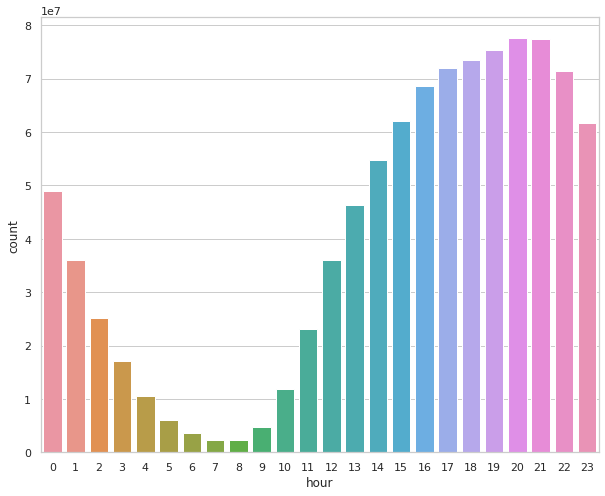

In [33]:
#set grid and font styles
sns.set(style="whitegrid")
#sns.set(font_scale=1.5)

#hourly distribution of messages 
size  = (10, 8)
fig, ax = plt.subplots(figsize = size)
#plt.xticks(rotation=45)
#ax = sns.distplot("hour","count", data=hp1, palette="plasma")
ax = sns.barplot(x="hour", y='count', data=hp2);

In [25]:
wp1 = trip_sum_CN.groupBy("weekday").count().orderBy("weekday").toPandas()

In [26]:
wp1

weekday      count
0     Friday  155552527
1     Monday  132054806
2   Saturday  136161570
3     Sunday  112283191
4   Thursday  149325183
5    Tuesday  139438247
6  Wednesday  143735355

In [27]:
wp1.dtypes

weekday    object
count       int64
dtype: object

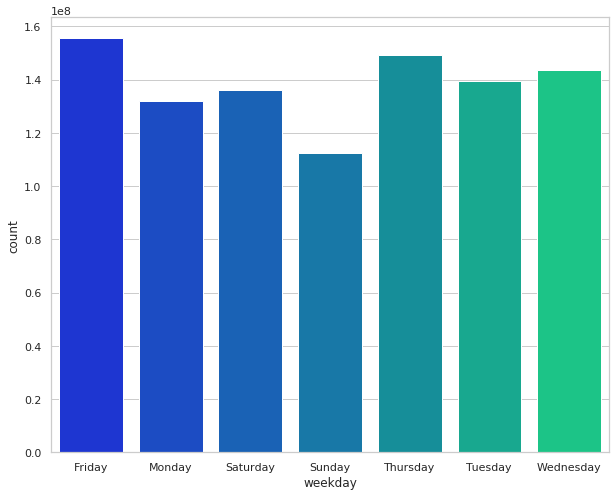

In [28]:
#set grid and font styles
sns.set(style="whitegrid")
#sns.set(font_scale=1.5)

#hourly distribution of messages 
size  = (10, 8)
fig, ax = plt.subplots(figsize = size)
ax = sns.barplot(x="weekday", y='count', data=wp1, palette="winter");

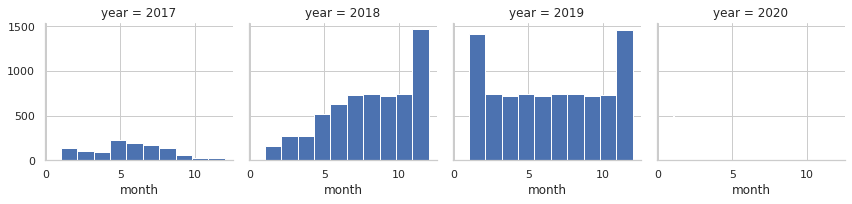

In [13]:
#df = sns.load_dataset('tips')
#size  = (15, 8)
#fig, ax = plt.subplots(figsize = size)
g = sns.FacetGrid(hp1, col = "year")
g.map(plt.hist, "month")
plt.show()

In [34]:
ex1 = hp1[(hp1['year']== 2017)].groupby(['month'], as_index=False)['count'].sum()
ex2 = hp1[(hp1['year']== 2018)].groupby(['month'], as_index=False)['count'].sum()
ex3 = hp1[(hp1['year']== 2019)].groupby(['month'], as_index=False)['count'].sum()
ex4 = hp1[(hp1['year']== 2020)].groupby(['month'], as_index=False)['count'].sum()

<Figure size 432x288 with 0 Axes>

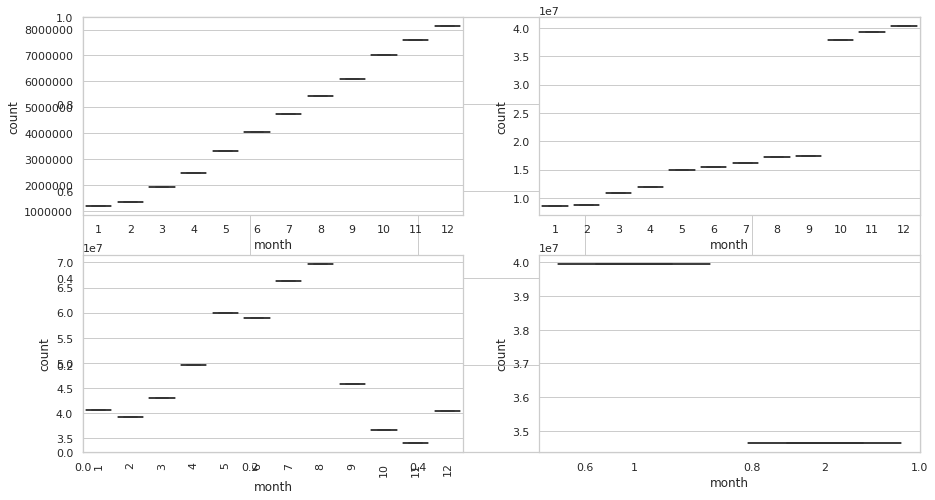

In [36]:
fig = plt.figure()
sns.set_style("whitegrid")
#sns.set_style("whitegrid", {'axes.grid' : False})
#fig.subplots_adjust(hspace=0.4, wspace=0.4)
size  = (15, 8)
fig, ax = plt.subplots(figsize = size)
ax = fig.add_subplot(2, 2, 1)
#sns.distplot(df.Principal,ax=ax)
ax = sns.boxplot(x="month", y="count", data=ex1, palette="winter")

ax = fig.add_subplot(2, 2, 2)
#sns.distplot(df.terms,ax=ax)
ax = sns.boxplot(x="month", y="count", data=ex2, palette="winter")

ax = fig.add_subplot(2, 2, 3)
ax = sns.boxplot(x="month", y="count", data=ex3, palette="winter")
#sns.barplot(data = df[['Less_than_College', 'college', 'Bachelor']],ax=ax)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax = fig.add_subplot(2, 2, 4)
#sns.boxplot(df['age'],ax=ax)
ax = sns.boxplot(x="month", y="count", data=ex4, palette="winter")
plt.show()

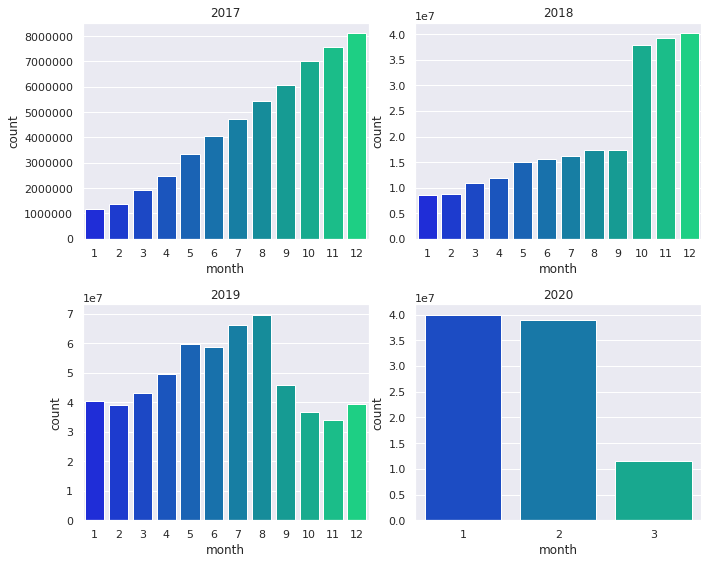

In [35]:
f = plt.figure(figsize=(10, 8))
gs = f.add_gridspec(2, 2)

with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[0, 0])
    sns.barplot(x="month", y="count", data=ex1, palette="winter").set_title("2017")

with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[0, 1])
    sns.barplot(x="month", y="count", data=ex2, palette="winter").set_title("2018")

with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[1, 0])
    sns.barplot(x="month", y="count", data=ex3, palette="winter").set_title("2019")

with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[1, 1])
    sns.barplot(x="month", y="count", data=ex4, palette="winter").set_title("2020")
  
f.tight_layout()

In [36]:
hp1.groupby(['year'], as_index=False)['count'].sum()

year      count
0  2016    2831263
1  2017   53296755
2  2018  238882974
3  2019  583094026
4  2020   90445861

## Country Code Analysis

In [37]:
# number of VINs with country code MULTI in NA Trip Summary:
# 448

In [38]:
multi_cn = spark.sql("SELECT count(distinct cvdcqa_vin_d_3) FROM cvdp.NCVDCQA_TRIP_SUM_FINAL_SEC_HTE WHERE cvdcqa_vin_d_3 IS NOT NULL AND cvdcqa_partition_region_x = 'NA' AND cvdcqa_partition_cntry_x = 'MULTI'")

In [39]:
#read TCU4G output

In [40]:
multi_cn = spark.sql("Select cvdc62_vin_d_3, cvdc62_rawpayloadmetadata_customer_countries_x from cvdp.ncvdc62_tcuftcp_msg_sec_hte where cvdc62_partition_region_x = 'NA' and cvdc62_partition_country_x = 'MULTI' and cvdc62_vin_d_3 IS NOT NULL group by cvdc62_vin_d_3, cvdc62_rawpayloadmetadata_customer_countries_x")

In [74]:
NA_cc = pd.read_csv('file:////s/lguerra5/NA_multi_VINS.txt', names=['d1','vin','customer_countries','d2'], skiprows=1, sep='|', converters={'customer_countries': lambda x: x[1:-1].split(',')})

In [75]:
NA_cc.drop(columns=['d1', 'd2'], inplace = True)

In [76]:
NA_cc.dtypes

vin                   object
customer_countries    object
dtype: object

In [84]:
NA_cc.reset_index(inplace=True)

In [85]:
NA_cc.head(20)

index                vin customer_countries
0       0  1FM5K8DH4KGA17629         [CAN, USA]
1       1  1FMCU9G90HUD61495         [CAN, USA]
2       2  1FMCU9G95HUD31960         [CAN, USA]
3       3  2FMPK4AP1KBB71381         [CAN, USA]
4       4  5LMJJ3LT5JEL00025         [CAN, USA]
5       5  1FM5K7F87KGA64077         [MEX, USA]
6       6  1FMCU9HDXKUB68040         [USA, CAN]
7       7  1FTEW1E55KFA41948         [USA, CAN]
8       8  1FTEW1E56KFB39712         [USA, CAN]
9       9  1FTFW1E41KFB53397         [USA, CAN]
10     10  1FMCU0J91LUA13556         [USA, MEX]
11     11  1FM5K8GT2KGA22750         [USA, CAN]
12     12  1FM5K8GT9KGA00809         [USA, CAN]
13     13  1FTEW1EB8KFA89661         [USA, CAN]
14     14  2LMPJ8LR4JBL23813         [USA, CAN]
15     15  5LMJJ3LT9JEL00027         [USA, CAN]
16     16  MAJ6P1CL3JC230784         [USA, CAN]
17     17  1FT8W3BT2KEC93657         [CAN, USA]
18     19  1FTFW1E4XKFC71528         [CAN, USA]
19     20  1FM5K8GT9KGA54157         [USA, CAN]

In [78]:
# dropping ALL duplicte values 
NA_cc.drop_duplicates(subset ="vin", keep = "first", inplace = True)

In [79]:
NA_cc.vin.nunique()

538

In [81]:
NA_cc.shape

(538, 2)

In [86]:
NA_cc.customer_countries[18]

['CAN', 'USA']

In [91]:
len(NA_cc.vin)

538

In [88]:
cn_count = 0
other_count = 0

In [89]:
for i in range(len(NA_cc.vin)):
    if "CAN" in NA_cc.customer_countries[i]:
        cn_count = cn_count+1
    else:
        other_count = other_count+1

In [90]:
print("Count with CAN use: ", cn_count)
print("Count with no CAN use: ", other_count)

Count with CAN use:  502
Count with no CAN use:  36


In [46]:
#what percentage is EU5?
float((TSdf[TSdf["customer_countries"].isin(["CAN"])].sum()["count"])/total_msg)*100
#float((TSdf[TSdf["cvdcqa_partition_cntry_x"].isin("GBR", "ITA", "ESP", "FRA", "DEU")].sum()["count"]/total_msg)*100)

87.99693452969633

In [58]:
#what percentage od messages are multi?
float(trip_sum_multi_total/(total_msg+trip_sum_multi_total))*100

0.03210097236311195

### Read in parquet file from HDFS - preprocessed EU data

In [9]:
# using SQLContext to read parquet file
#from pyspark.sql import SQLContext
#sqlContext = SQLContext(SparkContext)

# to read parquet file - EU Preprocessed
df = spark.read.parquet('hdfs://hdp2cluster/user/lguerra5/pae_processing_prod/trip_summary_preprocessed_subset/*')

In [10]:
df.show(5)

+-------------+------------------------+-----------------+-----------------+-----------+---------------+-----------------------+------------+--------------+-------------+
|trip_end_date|trip_end_eng_oil_percent|trip_end_odo_read|              vin|trip_number|oil_change_flag|oil_change_cycle_number|first_ol_pct|first_odometer|first_ol_date|
+-------------+------------------------+-----------------+-----------------+-----------+---------------+-----------------------+------------+--------------+-------------+
|   2019-05-14|                    35.0|             9448|1FM5K8D86JGC78159|       1834|              0|                      0|       100.0|         14867|   2019-09-12|
|   2019-05-14|                    35.0|             9448|1FM5K8D86JGC78159|       1835|              0|                      0|       100.0|         14867|   2019-09-12|
|   2019-05-14|                    35.0|             9461|1FM5K8D86JGC78159|       1836|              0|                      0|       100.0|    

In [11]:
df.printSchema()

root
 |-- trip_end_date: date (nullable = true)
 |-- trip_end_eng_oil_percent: float (nullable = true)
 |-- trip_end_odo_read: long (nullable = true)
 |-- vin: string (nullable = true)
 |-- trip_number: integer (nullable = true)
 |-- oil_change_flag: integer (nullable = true)
 |-- oil_change_cycle_number: integer (nullable = true)
 |-- first_ol_pct: float (nullable = true)
 |-- first_odometer: long (nullable = true)
 |-- first_ol_date: date (nullable = true)



In [12]:
#How many messages in preprocesed data?
prep_total_msg = df.count()

In [13]:
print(prep_total_msg)

327441440


In [ ]:
#% of messages that made it through pre-processing
foat(327441440/total_msg)*100

In [13]:
#how many distinct VINs in prep data?
total_cn_vins_prep = df.select("vin").distinct().count()
print(total_cn_vins_prep)

342889


In [ ]:
# Date range for both 

In [14]:
# Preprocessed Data
max_val1 = df.agg({"trip_end_date": "max"}).collect()[0][0]
min_val1 = df.agg({"trip_end_date": "min"}).collect()[0][0]

In [15]:
print(max_val1)
print(min_val1)

2020-03-05
2016-04-25


In [17]:
# Raw Trip Summay data
max_val2 = trip_sum_CN.agg({"trip_end_date": "max"}).collect()[0][0]
min_val2 = trip_sum_CN.agg({"trip_end_date": "min"}).collect()[0][0]

In [18]:
print(max_val2)
print(min_val2)

2020-03-06
2016-04-24


In [92]:
ex_case = trip_sum_CN[(trip_sum_CN.vin == '1FM5K8D86JGC78159')]

In [ ]:
ex_case.head(20)